In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

In [3]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [4]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 17)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [5]:
len(bvp)

360384

In [6]:
len(eda)

22524

In [7]:
len(temp)

22524

In [8]:
len(label)

3941700

In [9]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [10]:
# Criar o array numpy combinando os sinais e os rótulos
numpy_data = np.column_stack((aligned_bvp, aligned_eda, aligned_temp, label))
                
# Adicionar os dados deste diretório à lista de todos os dados
all_data.append(numpy_data)

# Converter a lista de arrays numpy em um único array numpy
combined_data = np.concatenate(all_data, axis=0)

In [11]:
column_names = ["bvp", "eda", "temp", "label"]

# Criar DataFrame
df = pd.DataFrame(data=combined_data, columns=column_names)

In [12]:
df

,bvp,eda,temp,label
0,-1.60,0.254602,29.43,0.0
1,-1.60,0.254602,29.43,0.0
2,-1.60,0.254602,29.43,0.0
3,-1.60,0.254602,29.43,0.0
4,-1.60,0.254602,29.43,0.0
...,...,...,...,...
3941695,84.97,0.412235,29.57,0.0
3941696,84.97,0.412235,29.57,0.0
3941697,84.97,0.412235,29.57,0.0
3941698,84.97,0.412235,29.57,0.0


In [13]:
# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df= df[df['label'] != 0.0]

In [14]:
df

,bvp,eda,temp,label
68859,-4.57,0.292984,29.41,1.0
68860,-4.57,0.292984,29.41,1.0
68861,-4.57,0.292984,29.41,1.0
68862,-4.57,0.292984,29.41,1.0
68863,-4.57,0.292984,29.41,1.0
...,...,...,...,...
3787954,8.76,0.417353,29.81,4.0
3787955,8.76,0.417353,29.81,4.0
3787956,8.76,0.417353,29.81,4.0
3787957,8.76,0.417353,29.81,4.0


In [15]:
X = df.drop(columns=["label"])  # Remove a coluna "label" para obter os recursos
y = df["label"] # 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
y = y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.999947845052392


Temperatura

In [17]:
temp_min = []
temp_max = []
temp_mean = []

for i in range(0, len(df), 3):
    temps = df['temp'].iloc[i:i+3]
    temp_min.append(temps.min())
    temp_max.append(temps.max())
    temp_mean.append(temps.mean())

temp_stats = pd.DataFrame({'temp_min': temp_min, 'temp_max': temp_max, 'temp_mean': temp_mean})

In [18]:
temp_min_array = np.array(temp_stats['temp_min'])
normalized_temp_min = preprocessing.normalize([temp_min_array])
temp_max_array = np.array(temp_stats['temp_max'])
normalized_temp_max = preprocessing.normalize([temp_max_array])
temp_mean_array = np.array(temp_stats['temp_mean'])
normalized_temp_mean = preprocessing.normalize([temp_mean_array])


In [19]:
data_temp = {
    'normalized_temp_mean': normalized_temp_mean.flatten(),
    'normalized_temp_max': normalized_temp_max.flatten(),
    'normalized_temp_min': normalized_temp_min.flatten()
}

df_temp = pd.DataFrame(data_temp)
df_temp.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min
0,0.001157,0.001157,0.001157
1,0.001157,0.001157,0.001157
2,0.001157,0.001157,0.001157
3,0.001157,0.001157,0.001157
4,0.001157,0.001157,0.001157



EDA

In [20]:
eda_min = []
eda_max = []
eda_mean = []
for i in range(0, len(df), 3):
    eda = df['eda'].iloc[i:i+3]
    eda_min.append(eda.min())
    eda_max.append(eda.max())
    eda_mean.append(eda.mean())

eda_stats = pd.DataFrame({'eda_min': eda_min, 'eda_max': eda_max, 'eda_mean': eda_mean})

In [21]:
print(eda_stats.head())

    eda_min   eda_max  eda_mean
0  0.292984  0.292984  0.292984
1  0.292984  0.292984  0.292984
2  0.292984  0.292984  0.292984
3  0.292984  0.292984  0.292984
4  0.292984  0.292984  0.292984


In [22]:
eda_min_array = np.array(eda_stats['eda_min'])
normalized_eda_min = preprocessing.normalize([eda_min_array])
eda_max_array = np.array(eda_stats['eda_max'])
normalized_eda_max = preprocessing.normalize([eda_max_array])
eda_mean_array = np.array(eda_stats['eda_mean'])
normalized_eda_mean = preprocessing.normalize([eda_mean_array])


In [23]:
data_eda = {
    'normalized_eda_mean': normalized_eda_mean.flatten(),
    'normalized_eda_max': normalized_eda_max.flatten(),
    'normalized_eda_min': normalized_eda_min.flatten()
}

df_eda = pd.DataFrame(data_eda)
df_eda.head()

,normalized_eda_mean,normalized_eda_max,normalized_eda_min
0,0.000344,0.000344,0.000344
1,0.000344,0.000344,0.000344
2,0.000344,0.000344,0.000344
3,0.000344,0.000344,0.000344
4,0.000344,0.000344,0.000344


BVP

In [24]:
folder_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD\S2\S2_E4_Data\HR.csv"
# Lendo o arquivo CSV
hr_data = pd.read_csv(folder_path)

# Imprimindo os dados
#print(hr_data)

#plt.figure(figsize=(12,6))

#plt.plot(hr_data.values)
#plt.show()
hr_data.tail()

,1495437335.000000
7861,81.38
7862,82.03
7863,82.67
7864,83.35
7865,84.03


In [25]:
folder_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD\S2\S2_E4_Data\bvp.csv"
# Lendo o arquivo CSV
bvp_data = pd.read_csv(folder_path)
bvp_data.head()
bvp_data.tail()


,1495437325.00
503939,96.51
503940,92.92
503941,85.61
503942,75.98
503943,65.86


In [26]:
bvp_min = []
bvp_max = []
bvp_mean = []
for i in range(0, len(df), 3):
    bvp = df['bvp'].iloc[i:i+3]
    bvp_min.append(bvp.min())
    bvp_max.append(bvp.max())
    bvp_mean.append(bvp.mean())

bvp_stats = pd.DataFrame({'bvp_min': bvp_min, 'bvp_max': bvp_max, 'bvp_mean': bvp_mean})

bvp_min_array = np.array(bvp_stats['bvp_min'])
normalized_bvp_min = preprocessing.normalize([bvp_min_array])
bvp_max_array = np.array(bvp_stats['bvp_max'])
normalized_bvp_max = preprocessing.normalize([bvp_max_array])
bvp_mean_array = np.array(bvp_stats['bvp_mean'])
normalized_bvp_mean = preprocessing.normalize([bvp_mean_array])

In [27]:
data_bvp = {
    'normalized_bvp_mean': normalized_bvp_mean.flatten(),
    'normalized_bvp_max': normalized_bvp_max.flatten(),
    'normalized_bvp_min': normalized_bvp_min.flatten()
}

df_bvp = pd.DataFrame(data_bvp)
df_bvp.head()

##se eu trocar pelos outros arquivos csv, eu vou perder a referencia da label

,normalized_bvp_mean,normalized_bvp_max,normalized_bvp_min
0,-0.000218,-0.000218,-0.000218
1,-0.000218,-0.000218,-0.000218
2,-0.000218,-0.000218,-0.000218
3,-0.000168,-0.000168,-0.000168
4,-0.000168,-0.000168,-0.000168


In [28]:
df_normalizado = pd.concat([df_temp, df_eda, df_bvp], axis=1)
df_normalizado.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_bvp_mean,normalized_bvp_max,normalized_bvp_min
0,0.001157,0.001157,0.001157,0.000344,0.000344,0.000344,-0.000218,-0.000218,-0.000218
1,0.001157,0.001157,0.001157,0.000344,0.000344,0.000344,-0.000218,-0.000218,-0.000218
2,0.001157,0.001157,0.001157,0.000344,0.000344,0.000344,-0.000218,-0.000218,-0.000218
3,0.001157,0.001157,0.001157,0.000344,0.000344,0.000344,-0.000168,-0.000168,-0.000168
4,0.001157,0.001157,0.001157,0.000344,0.000344,0.000344,-0.000168,-0.000168,-0.000168


In [29]:
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_bvp_mean,normalized_bvp_max,normalized_bvp_min
703029,0.001172,0.001172,0.001172,0.00049,0.00049,0.00049,0.000423,0.000435,0.000418
703030,0.001172,0.001172,0.001172,0.00049,0.00049,0.00049,0.000418,0.000418,0.000418
703031,0.001172,0.001172,0.001172,0.00049,0.00049,0.00049,0.000418,0.000418,0.000418
703032,0.001172,0.001172,0.001172,0.00049,0.00049,0.00049,0.000418,0.000418,0.000418
703033,0.001172,0.001172,0.001172,0.00049,0.00049,0.00049,0.000403,0.000403,0.000402


Random Forest

In [30]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})
label_stats.head()

,label_mean
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [31]:
label_stats.tail()

,label_mean
703029,4.0
703030,4.0
703031,4.0
703032,4.0
703033,4.0


In [32]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_set, labels, random_state=0)

In [33]:
# acurácia do rf
clf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9997781052463885

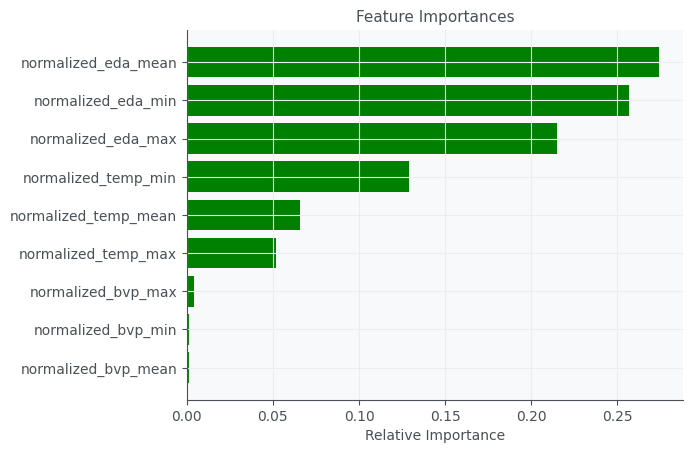

In [34]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

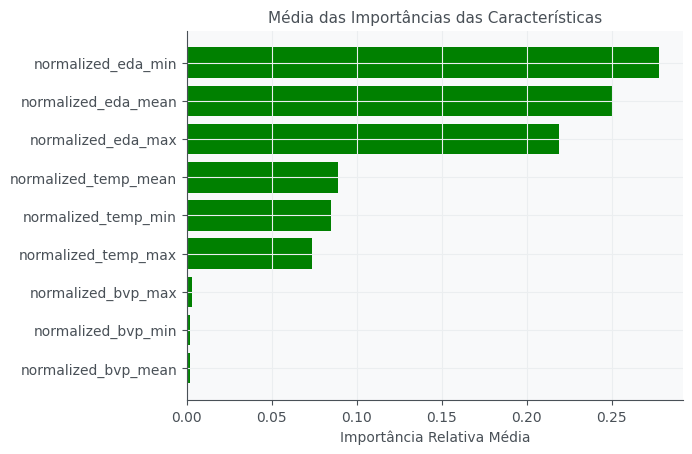

In [35]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()